## This notebook fine-tunes the Roberta Base model for ham/spam classification.

In [1]:
! pip install datasets evaluate transformers[sentencepiece];
! pip install -U accelerate;
! pip install -U transformers;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [3]:
! pip install urlextract

In [12]:
import torch
import pandas as pd
import numpy as np
import re
import evaluate
from accelerate import Accelerator
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, get_scheduler
from datasets import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
import urlextract
from tqdm.auto import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Import some pre-processing functions to try:

In [28]:
from text_processing_functions import remove_urls_by_tld, replace_word_containing, remove_numbers_from_text, remove_currency_from_text

Set the tokenizer and model to the Roberta Base checkpoint, and initialise the data collator:

In [5]:
checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Create a Scikit-learn pipeline to run some text pre-processing:

In [6]:
# top-level domains to replace in texts:
REAL_TLDS = ["com", "org.uk", "net", "co.uk", "biz", "edu", "ac", "edu.sg", "tv"]

pre_processer_pipeline = make_pipeline(
    FunctionTransformer(
        remove_urls_by_tld,
        kw_args=dict(tld_list=REAL_TLDS, replace_str="http"),
    ),
    FunctionTransformer(
        replace_word_containing,
        kw_args=dict(str_contains_list=["http", "www", "co.uk"], replacement="http"),
    ),
    FunctionTransformer(
        remove_numbers_from_text,
        kw_args=dict(
            min_digits=5,
            max_word_length=20,
            replace_str="phonenumber",
        ),
    ),
    FunctionTransformer(
        remove_currency_from_text,
        kw_args=dict(replace_str="currencystring"),
    )
)

Import the data and use Sklearn to make a stratified split for training and evaluation:

In [14]:
rng = np.random.RandomState(0)
df = pd.read_csv(f"SMSSpamCollection", sep='\t', names=["labels", "text"])
df = df.drop_duplicates(ignore_index=False)
df["labels"] = df["labels"].replace(["ham", "spam"], [0, 1])
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["labels"], test_size=0.2, random_state=rng, stratify=df["labels"])
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)


Run the Sklearn pre-processing pipeline:

In [15]:
df_train["text"] = pre_processer_pipeline.fit_transform(df_train["text"])
df_test["text"] = pre_processer_pipeline.fit_transform(df_test["text"])

Convert the dataframes into datasets:

In [16]:
train_ds = Dataset.from_pandas(df_train, split="train", preserve_index=False)
test_ds = Dataset.from_pandas(df_test, split="test", preserve_index=False)

Create functions for tokenization:

In [17]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)


def tokenize_dataset(dataset, cols_to_remove: list[str] | None = None):
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    if cols_to_remove is not None:
        tokenized_dataset = tokenized_dataset.remove_columns(cols_to_remove)
    tokenized_dataset.set_format("torch")
    return tokenized_dataset

In [18]:
tokenized_train_ds = tokenize_dataset(dataset=train_ds, cols_to_remove=["text"])
tokenized_test_ds = tokenize_dataset(dataset=test_ds, cols_to_remove=["text"])

Map:   0%|          | 0/4135 [00:00<?, ? examples/s]

Map:   0%|          | 0/1034 [00:00<?, ? examples/s]

Prepare the dataloaders:

In [19]:
train_dataloader = DataLoader(
    tokenized_train_ds, shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_test_ds, batch_size=8, collate_fn=data_collator
)

Create and run a training loop:

In [20]:
optimizer = AdamW(model.parameters(), lr=3e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/2585 [00:00<?, ?it/s]

Get metrics from trained model and batched data:

In [21]:
def compute_metrics(model, dataloader) -> dict:
    metric=evaluate.combine(["accuracy", "recall", "precision", "f1"])
    model.eval()

    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])

    return metric.compute()

In [22]:
eval_metrics = compute_metrics(model=model, dataloader=eval_dataloader)

Retrieve the predictions and labels from the batched data:

In [23]:
def get_preds_labels_from_batches(dataloader) -> dict:
    labels = []
    preds = []
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        labels.append(batch["labels"].tolist())
        preds.append(predictions.tolist())

    labels = [item for row in labels for item in row]
    preds = [item for row in preds for item in row]

    return {"labels":labels, "predictions":preds}

In [24]:
eval_results = get_preds_labels_from_batches(dataloader=eval_dataloader)

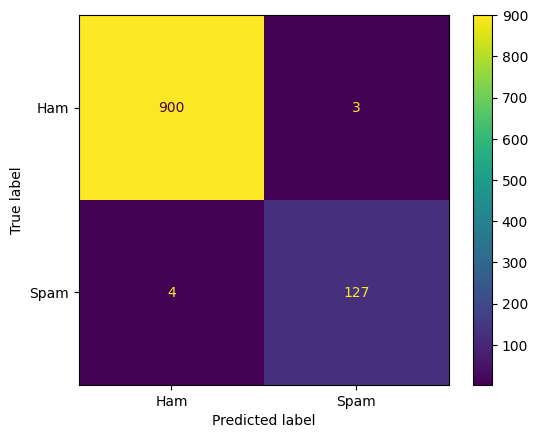

In [25]:
cm_test = confusion_matrix(eval_results["labels"], eval_results["predictions"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Ham", "Spam"])
disp.plot();

In [26]:
print(eval_metrics)

{'accuracy': 0.9932301740812379, 'recall': 0.9694656488549618, 'precision': 0.9769230769230769, 'f1': 0.9731800766283524}
